<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Voxelize" data-toc-modified-id="Voxelize-1">Voxelize</a></span><ul class="toc-item"><li><span><a href="#Terrain" data-toc-modified-id="Terrain-1.1">Terrain</a></span></li><li><span><a href="#Buildings" data-toc-modified-id="Buildings-1.2">Buildings</a></span></li></ul></li></ul></div>

In [1]:
import rasterio
from rasterio import features
import sqlite3
from matplotlib import pyplot
from shapely import wkb
import numpy as np
import math
from matplotlib import pyplot as plt

In [2]:
# Get the building data
conn = sqlite3.connect('data/witten-processed.sqlite')
conn.enable_load_extension(True)
conn.execute('SELECT load_extension("mod_spatialite")')
conn.row_factory = lambda c, r: dict(zip([col[0] for col in c.description], r))
result = conn.execute('SELECT osm_id, ground_height, CAST(height as decimal) as height, ST_AsBinary(ST_Transform(GEOMETRY, 5555)) as wkb from osm_buildings')
buildings = result.fetchall()


In [3]:
sample_building = wkb.loads(buildings[0]['wkb'])
sample_building

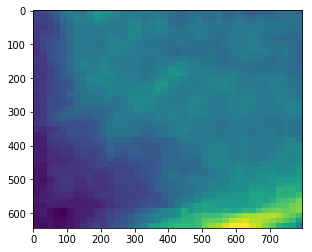

In [4]:
# Plot the Elevation Data
src = rasterio.open("data/witten_elevation_5555_cropped_2.tif")
pyplot.imshow(src.read(1))
pyplot.show()

In [17]:
affine = src.meta['transform']
src.meta['crs']['init']

'epsg:25832'

BBOX for the image

384076.63, 385670.25, 5699397.29, 5700685.23

bbox_min = utm.from_latlon(51.4339, 7.3323)

bbox_max = utm.from_latlon(51.4458, 7.3548)

In [35]:
values = src.read(1)
height_diff = values.max() - values.min()
height_diff = height_diff + 13 # give yourself 10 meters of flying room
resolution = round(src.meta['transform'][0]) # get the x axis resolution, round to an integer
z_dim = int(height_diff/ resolution)
# meta = {'res': resolution, }
x_dim = src.meta['width']
y_dim = src.meta['height']
terrain_map = np.zeros((y_dim, x_dim, z_dim), dtype=np.uint8)
# src.meta
terrain_map.shape
# values.max()
# # values.min()
print(values.min(),values.max(), terrain_map.shape)
# src.meta

93 160 (644, 797, 40)


5699397

## Voxelize 

### Terrain

Terrain elevation is discretized and placed within the voxel grid map.


### Buildings

Get all the builidings in the map. The polygon should be in coordinate system of the terrain raster.

We have 45 lists of buildings, each list corresponding to an elevation slice.
If a buildings ground height and max height is within the slice, add it to the list. 

Each list is rasterized and placed within the map at its corresponding elevation slice.


In [36]:
def voxelize_terrain(terrain_map, raster, res=2,height_buffer=5):
    min_val = raster.min()
    z_dim = terrain_map.shape[2]
#     print(z_dim)
    for i in range(z_dim):
        height = min_val + i * 2
        low_i = max(i-height_buffer, 0)
        mask = (raster >= height) & (raster <= height + res)
#         print(mask)
        terrain_map[mask, low_i:i+1] = 255
    return terrain_map
    
def real_to_index(val, val_min, val_max, res=2.0):
    index = math.floor((val - val_min) / res)
    return min(max(index, 0), (val_max - val_min) / 2.0)

def index_to_real(index, val_min, res=2.0):
    real = val_min + index * res
    return real

def overlap(a, b):
    return a[1] >= b[0] and a[0] <= b[1]
    
def voxelize_buildings(map_slice, buildings, value=254):
    build_features = []
    for building in buildings:
        shape = wkb.loads(building['wkb'])
        build_features.append((shape, value))
    features.rasterize(build_features, out_shape=map_slice.shape, out=map_slice, transform=src.meta['transform'] )

def voxelize_building_layers(terrain_map, buildings, z_min, res=2.0, value=254):
    z_dim = terrain_map.shape[2]
    building_voxels = np.zeros_like(terrain_map)
    for i in range(z_dim):
        low_real = index_to_real(i, z_min, res)
        high_real = index_to_real(i + 1, z_min, res)
        lyr_buildings = [building for building in buildings if overlap([building['ground_height'], building['ground_height'] + building['height']], [low_real, high_real] ) ]
        if lyr_buildings:
            voxelize_buildings(building_voxels[:,:,i], lyr_buildings, value=value)
    return building_voxels
    
voxel_terrain = voxelize_terrain(terrain_map, values)
voxel_building = voxelize_building_layers(terrain_map, buildings, values.min())
voxel_all = voxel_terrain.copy()

mask = voxel_building == 254
voxel_all[mask] = 255

# Save the Data
np.save('data/witten_terrain.npy', voxel_terrain)
np.save('data/witten_buildings.npy', voxel_building)
np.save('data/witten_all.npy', np.flip(voxel_all, 0))

### Potential Field

Create a potential Field around buildings

```
For each layer (zslice)
 each building that is inside the layer slice
     create 5 enlarged versions of the buiding. 2 meter radius, 4 meter radius, ... 10 meter radius buffer
     rasterize the building in its repecive slice
     for each layer above the building 
 combine the 5 raster slices, preference goes to inner slice
 
```

Basically create 5 lists of 'buildings' for every z slice. Each list is for either 2, 4, 6, 8, or 10 meters away buffer radius of buildiings. 

For side buffer - For every z slice, filter this list of 5 buldings to only include buildings that are within the layers slice.

For buffer on top - 2 meters above should have up to 8 meters, 4 meters above top of building should have up to 6 meters, etc.

  
For 


     



In [37]:
sql_qry_buildings = "SELECT osm_id,  ground_height, ground_height + CAST(height as decimal) as total_height, ST_AsBinary(st_buffer(st_transform(geometry, 5555), ?)) as wkb FROM osm_buildings"

def get_building_lists(start=2, end=8, step=2):
    buildings_list = []
    for dist in range(start,end,step):
        result = conn.execute(sql_qry_buildings, (dist,))
        buildings_list.append(result.fetchall())
    return buildings_list
# result
expanded_buildings = get_building_lists()

In [38]:
wkb.loads(expanded_buildings[0][0]['wkb'])
# len(buildings[0])
# len(expanded_buildings)

In [39]:
def filter_buildings(building_list, low_real, high_real, res=2):
    expanded_buildings = []
    build_depth = len(building_list)
    for idx, buildings in enumerate(building_list):
        side_buildings = [building for building in buildings if overlap([building['ground_height'], building['total_height']], [low_real, high_real] ) ]
        top_buidlings = [building for building in buildings if (low_real - building['total_height'] < build_depth * res and low_real - building['total_height'] >=0)]
        
        side_buildings.extend(top_buidlings)
        expanded_buildings.append(side_buildings)

    return expanded_buildings

def merge_3D_to_2D(three_d):
    depth = three_d.shape[2]
    final = np.copy(three_d[:,:,depth-1])
    for i in reversed(range(0,depth-1)):
        mask = three_d[:,:,i] == i + 1
        final[mask] = i+1
    return final
    

def create_potential_field(terrain_map, buildings, z_min, res=2):
    z_dim = terrain_map.shape[2]
    potential_field = np.zeros_like(terrain_map)
    field_cell_depth = len(buildings)
    for i in range(z_dim):
        # Will hold the potential field slices, radiating outward from a building
        potential_field_temp = np.zeros(shape=(terrain_map.shape[0:2] + (field_cell_depth,)))
        # The real world height range this slice in the z dimension is referring to
        low_real = index_to_real(i, z_min, res)
        high_real = index_to_real(i + 1, z_min, res)
        # side_buildings - filtered list of expanded building outlines that are within this height buffer radiating out the sides of the building
        # top_buildigns - a filtered list of expanded buildings outlines that are ABOVE this height buffer radiating ABOVE the the top of the building
        expanded_buildings = filter_buildings(buildings, low_real, high_real)
        #some top buildings will need less 
        if expanded_buildings:
            for j in range(field_cell_depth):
                if expanded_buildings[j]:
                    voxelize_buildings(potential_field_temp[:,:,j], expanded_buildings[j], value=j+1)
                    
        potential_field[:,:,i] = merge_3D_to_2D(potential_field_temp)
    
    return potential_field

voxel_potential_field = create_potential_field(voxel_all, expanded_buildings, values.min())


Combine the potential field and the occupancy grid

In [40]:
voxel_all_pf = voxel_potential_field.copy()
voxel_all_pf = voxel_all_pf * 60
mask = voxel_all == 255
voxel_all_pf[mask] = 255
# mask = voxel_all == 255
# voxel_all_pf[mask] = 255
voxel_all_pf = np.flip(voxel_all_pf, 0)

np.save('data/witten_all_pf.npy', voxel_all_pf)


### LIDAR Point Cloud

Convert voxel obstacles to a LIDAR Point for purely visualization purposes. You can use any lidar point cloud viewer to visualize. I recommonend plas.io


In [41]:
from laspy.file import File, header

def voxel_to_numpy(voxels, min_value=1):
    reduced_voxels = voxels[voxels >= min_value]
    num_points = reduced_voxels.shape[0]
    data = np.zeros(shape=(num_points, 4))
    it = np.nditer(voxels, flags=['multi_index'])
    count = 0
    while not it.finished:
        if it[0] >= 1:
            data[count, 0:3]= it.multi_index
            data[count, 3] = it[0]
            count += 1
        it.iternext()
    return data




def make_las_file(data, file_name='data/witten_all.laz'):
    my_header = header.Header()
    outFile = File(file_name, mode='w', header=my_header)

    outFile.header.offset = np.amin(data, axis=0)[0:3]
    outFile.header.scale = [1,1,1]

    outFile.x = data[:, 0]
    outFile.y = data[:, 1]
    outFile.z = data[:, 2]
    outFile.raw_classification = data[:,3]
    
    outFile.close()
    

# voxel_np = voxel_to_numpy(voxel_all)
# pf_np = voxel_to_numpy(voxel_potential_field)
pf_all_np = voxel_to_numpy(voxel_all_pf)
# make_las_file(voxel_np,file_name='data/witten_all.laz')
# make_las_file(pf_np, file_name='data/witten_pf.laz')
make_las_file(pf_all_np, file_name='data/witten_all_pf.laz')

In [27]:
previous_voxels = np.load('data/total_bin_mesh_res002.npy')
previous_np = voxel_to_numpy(previous_voxels)
make_las_file(previous_np, file_name='data/total_bin_mesh_res002.laz')